In [38]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

from numpy.random import normal

from muldoon import met_timeseries
from muldoon.utils import modified_lorentzian

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


0.19315138753268438
True
499


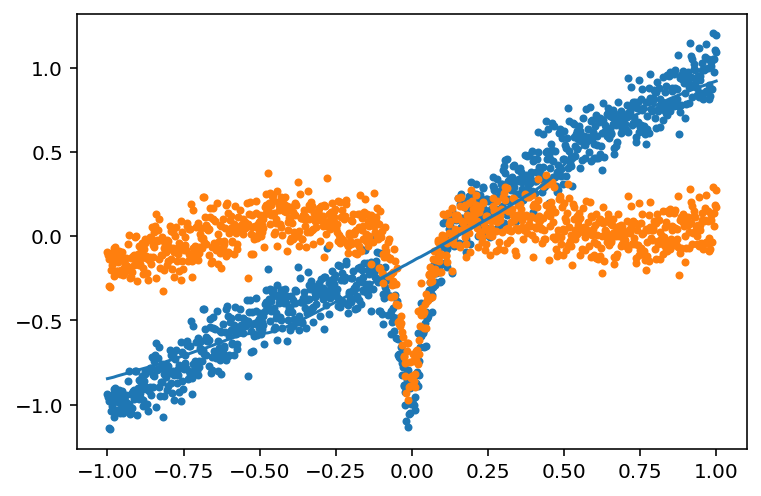

In [13]:
# Create time-series
time = np.linspace(-1, 1, 1000)
baseline = 0.
slope = 1.
t0 = 0.
DeltaP = 1.
Gamma = 0.1
profile = modified_lorentzian(time, baseline, slope, t0, DeltaP, Gamma) + normal(scale=slope/10., size=len(time))
mt = met_timeseries(time, profile)
# Detrend
window_size = 10*Gamma
detrended_pressure = mt.detrend_pressure_timeseries(window_size)
print(np.std(mt.detrended_pressure))
print(np.isclose(np.std(mt.detrended_pressure), 0.2, atol=0.1))

plt.scatter(mt.time, mt.pressure, marker='.')
plt.scatter(mt.time, mt.detrended_pressure, marker='.')
plt.plot(mt.time, mt.pressure_trend)

In [7]:
# Test time-series write-out
write_str = mt.write_out_detrended_timeseries(test_mode=True)
print(write_str);

# time, pressure
-1, -0.0476288
-0.997998, -0.323928
-0.995996, -0.174894
-0.993994, -0.525886
-0.991992, -0.264505
-0.98999, -0.138508
-0.987988, -0.212954
-0.985986, -0.391914
-0.983984, -0.182274
-0.981982, -0.417734
-0.97998, -0.193137
-0.977978, 0.127007
-0.975976, -0.0827968
-0.973974, -0.245346
-0.971972, -0.197549
-0.96997, -0.108163
-0.967968, -0.0293289
-0.965966, -0.062057
-0.963964, -0.265119
-0.961962, -0.18605
-0.95996, -0.272605
-0.957958, -0.141947
-0.955956, -0.129326
-0.953954, -0.0480108
-0.951952, -0.233806
-0.94995, -0.0765399
-0.947948, -0.417488
-0.945946, -0.0877179
-0.943944, -0.205148
-0.941942, -0.293344
-0.93994, -0.290395
-0.937938, -0.216062
-0.935936, -0.0667737
-0.933934, -0.204324
-0.931932, -0.227231
-0.92993, 0.103741
-0.927928, -0.174742
-0.925926, -0.0618563
-0.923924, -0.144648
-0.921922, -0.379098
-0.91992, -0.220123
-0.917918, -0.138829
-0.915916, -0.0312227
-0.913914, -0.222409
-0.911912, -0.0796037
-0.90991, -0.0438844
-0.907908, -0.0623865
-0.

In [54]:
from scipy.stats import mode
print(mt.time[1:] - mt.time[0:-1])
print(mode(mt.time[1:] - mt.time[0:-1]).mode[0])

[0.002002 0.002002 0.002002 0.002002 0.002002 0.002002 0.002002 0.002002
 0.002002 0.002002 0.002002 0.002002 0.002002 0.002002 0.002002 0.002002
 0.002002 0.002002 0.002002 0.002002 0.002002 0.002002 0.002002 0.002002
 0.002002 0.002002 0.002002 0.002002 0.002002 0.002002 0.002002 0.002002
 0.002002 0.002002 0.002002 0.002002 0.002002 0.002002 0.002002 0.002002
 0.002002 0.002002 0.002002 0.002002 0.002002 0.002002 0.002002 0.002002
 0.002002 0.002002 0.002002 0.002002 0.002002 0.002002 0.002002 0.002002
 0.002002 0.002002 0.002002 0.002002 0.002002 0.002002 0.002002 0.002002
 0.002002 0.002002 0.002002 0.002002 0.002002 0.002002 0.002002 0.002002
 0.002002 0.002002 0.002002 0.002002 0.002002 0.002002 0.002002 0.002002
 0.002002 0.002002 0.002002 0.002002 0.002002 0.002002 0.002002 0.002002
 0.002002 0.002002 0.002002 0.002002 0.002002 0.002002 0.002002 0.002002
 0.002002 0.002002 0.002002 0.002002 0.002002 0.002002 0.002002 0.002002
 0.002002 0.002002 0.002002 0.002002 0.002002 0.002

13.52492868486711 0.0030030030030030463 0.004004004004003914


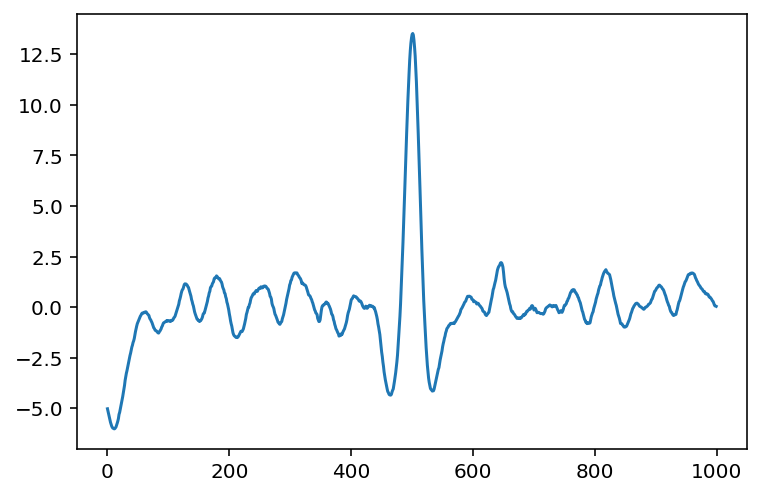

In [37]:
# Create time-series
time = np.linspace(-1, 1, 1000)
baseline = 0.
slope = 1.
t0 = 0.
DeltaP = 1.
Gamma = 0.01
profile = modified_lorentzian(time, baseline, slope, t0, DeltaP, Gamma) + normal(scale=slope/10., size=len(time))
mt = met_timeseries(time, profile)
# Detrend
window_size = 10*Gamma
detrended_pressure = mt.detrend_pressure_timeseries(window_size) 
# plt.plot(mt.time, profile)
conv = mt.apply_lorentzian_matched_filter(10.*Gamma, 1./np.pi)
mx_ind = np.argmax(mt.convolution)

print(mt.convolution[mx_ind], np.abs(mt.time[mx_ind]), 2.*mt.sampling)
# plt.plot(mt.time, mt.convolution)
# plt.plot(mt.time, profile)
plt.plot(mt.convolution)
# Make sure convolution returns a strong peak at the right time
# assert ((np.abs(mt.time[mx_ind]) < Gamma) & (mt.convolution[mx_ind] > 7.))